In [1]:
import signac
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import gsd.hoomd

In [2]:
# load project to get rigid simulations
project = signac.get_project("../pps_rigid_sims/")
jobs = list(project.find_jobs())
len(jobs)

2

In [9]:
for job in jobs:
    print('************')
    print(job.id)
    
    print(job.sp.init_rigid_snap)

************
ec9677d24c248f918502f1239baa456d
/home/marjanalbooyeh/Aniso_ML_MD_project/may_23_Aniso/Aniso_MLMD/aniso_per_particle/sampling/pps_rigid_sims/assets/rigid_after_shrink_800_d_0.8.gsd
************
6c991d43877779bf4714eb2f968f2d8b
/home/marjanalbooyeh/Aniso_ML_MD_project/may_23_Aniso/Aniso_MLMD/aniso_per_particle/sampling/pps_rigid_sims/assets/rigid_after_shrink_800_d_0.95.gsd


In [14]:
help(project.open_job)

Help on method open_job in module signac.contrib.project:

open_job(statepoint=None, id=None) method of signac.contrib.project.Project instance
    Get a job handle associated with a state point.
    
    This method returns the job instance associated with
    the given state point or job id.
    Opening a job by a valid state point never fails.
    Opening a job by id requires a lookup of the state point
    from the job id, which may fail if the job was not
    previously initialized.
    
    Parameters
    ----------
    statepoint : dict
        The job's unique set of state point parameters (Default value = None).
    id : str
        The job id (Default value = None).
    
    Returns
    -------
    :class:`~signac.contrib.job.Job`
        The job instance.
    
    Raises
    ------
    KeyError
        If the attempt to open the job by id fails.
    LookupError
        If the attempt to open the job by an abbreviated id returns more
        than one match.



In [17]:
selected_job_id = '6c991d43877779bf4714eb2f968f2d8b'
selected_job = project.open_job(id=selected_job_id)
selected_job

Job(project=Project.get_project('/home/marjanalbooyeh/Aniso_ML_MD_project/may_23_Aniso/Aniso_MLMD/aniso_per_particle/sampling/pps_rigid_sims'), statepoint={'kT': 1.4, 'n_steps': 6000000.0, 'n_tries': 2, 'ff_path': '/home/marjanalbooyeh/Aniso_ML_MD_project/may_23_Aniso/Aniso_MLMD/aniso_per_particle/sampling/pps_rigid_sims/assets/pps_ff.pkl', 'init_rigid_snap': '/home/marjanalbooyeh/Aniso_ML_MD_project/may_23_Aniso/Aniso_MLMD/aniso_per_particle/sampling/pps_rigid_sims/assets/rigid_after_shrink_800_d_0.95.gsd', 'const_rel_pos': '/home/marjanalbooyeh/Aniso_ML_MD_project/may_23_Aniso/Aniso_MLMD/aniso_per_particle/sampling/pps_rigid_sims/assets/const_rel_pos.npy'})

In [18]:
traj = gsd.hoomd.open(selected_job.fn("trajectory.gsd"))
print(f"{len(traj)}")

1200


In [6]:
color = cm.rainbow(np.linspace(0, 1, len(kT_range)))

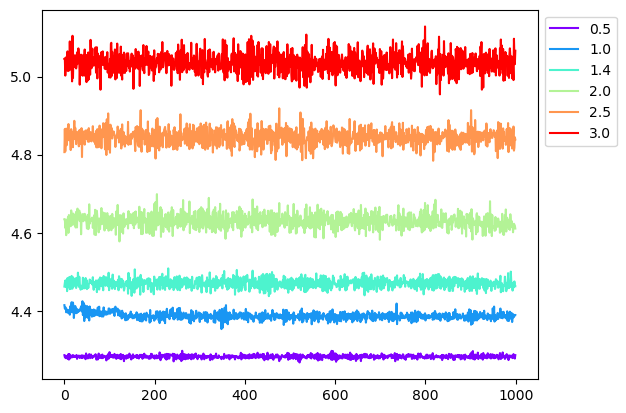

In [7]:
for i, kT in enumerate(kT_range):
    job = list(project.find_jobs(filter={'kT': kT}))[0]
    log = np.genfromtxt(job.fn("log.txt"), names=True)
    potential_energy = log['mdcomputeThermodynamicQuantitiespotential_energy'][-1000:] / (800*7)
    plt.plot(potential_energy, label=kT, c=color[i])
plt.legend(bbox_to_anchor=(1., 1.))

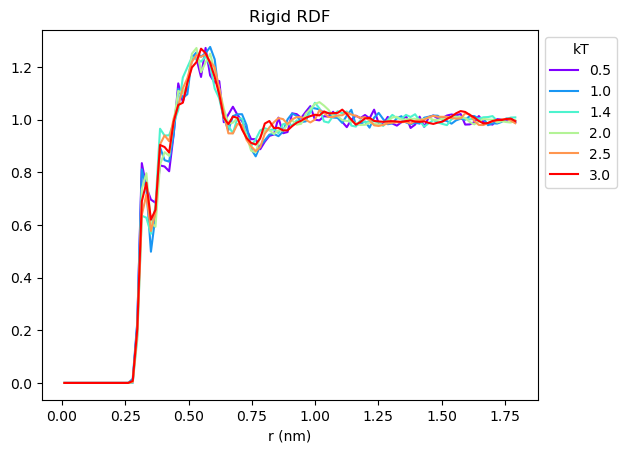

In [8]:
idx = -100
for i, kT in enumerate(kT_range):
    job = list(project.find_jobs(filter={'kT': kT}))[0]
    traj_gsd = job.fn("trajectory.gsd")
    rdf, rdf_norm = gsd_rdf(gsdfile=traj_gsd, A_name="rigid", B_name="rigid",r_max=5, start=idx, stop=-1)
    plt.plot(rdf.bin_centers * 0.36, rdf.rdf * rdf_norm, label=kT, c=color[i])
plt.legend(title="kT", bbox_to_anchor=(1., 1.))
plt.xlabel("r (nm)")
plt.title("Rigid RDF")
plt.savefig("Rigid_RDF.png")

## Gather all frames from trajectories of a selected kT

In [5]:
selected_kT = [1.4]

In [6]:
all_frames = []
for kT in selected_kT:
    job = list(project.find_jobs(filter={'kT': kT}))[0]
    traj = gsd.hoomd.open(job.fn("trajectory.gsd"))
    for frame in traj[-1000:]:
        all_frames.append(frame)

In [7]:
len(all_frames)

1000

In [8]:
zero_energy_frames = []
for i, f in enumerate(all_frames):
    if f.log['md/compute/ThermodynamicQuantities/potential_energy'][0] == 0:
        zero_energy_frames.append(i)
len(zero_energy_frames)

0

In [9]:
forces = []
torques = []
energies = []
N_rigid= 800
for frame in all_frames:
    forces.append(frame.log['particles/md/constrain/Rigid/forces'][:N_rigid])
    torques.append(frame.log['particles/md/constrain/Rigid/torques'][:N_rigid])
    energies.append(frame.log['md/compute/ThermodynamicQuantities/potential_energy'][:N_rigid])
forces = np.asarray(forces)   
torques = np.asarray(torques)
energies = np.asarray(energies)

## check force distribution

In [10]:
forces.shape

(1000, 800, 3)

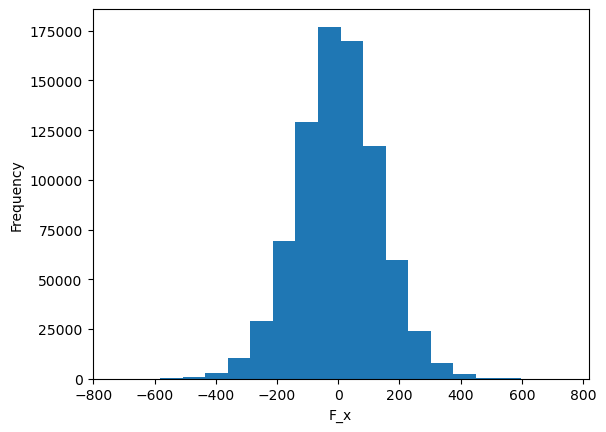

In [11]:
f_x = forces[:, :, 0].reshape(-1, 1).squeeze()
plt.hist(f_x, bins=20)

plt.xlabel('F_x')
plt.ylabel('Frequency')
plt.show()

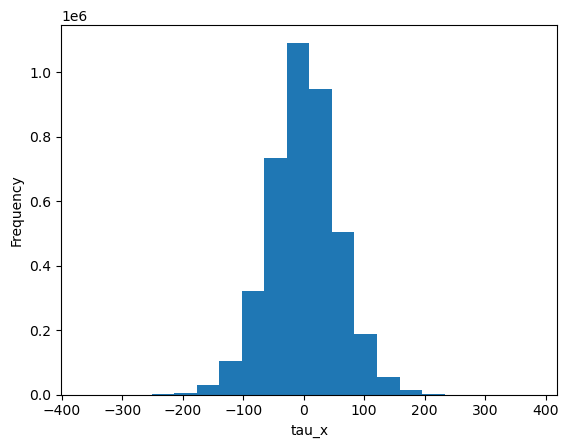

In [21]:

tau_x = torques[:, :, 0].reshape(-1, 1).squeeze()
plt.hist(tau_x, bins=20)

plt.xlabel('tau_x')
plt.ylabel('Frequency')
plt.show()

In [12]:
force_data = forces.reshape(-1, 3)
print(f'Mean: {force_data.mean(axis=0)}')
print(f'std: {force_data.std(axis=0)}')
print(f'Max: {force_data.max(axis=0)}')
print(f'Min: {force_data.min(axis=0)}')
print('********************************')

torque_data = torques.reshape(-1, 3)
print(f'Mean: {torque_data.mean(axis=0)}')
print(f'std: {torque_data.std(axis=0)}')
print(f'Max: {torque_data.max(axis=0)}')
print(f'Min: {torque_data.min(axis=0)}')

Mean: [1.10489395e-17 1.71311854e-16 2.13304929e-16]
std: [133.77787519 134.10274485 134.39301611]
Max: [744.18612763 745.86528452 764.83838627]
Min: [-729.42352842 -814.03686614 -774.11868931]
********************************
Mean: [-0.00658833  0.00699358 -0.12473369]
std: [56.28347634 56.33663637 58.0169751 ]
Max: [325.7220612  346.76616132 335.57075524]
Min: [-329.12040658 -446.46978691 -377.47823705]


# shuffle frames

In [12]:
import numpy as np
frame_idx = np.arange(len(all_frames))
np.random.shuffle(frame_idx)
frame_idx[:10]

array([526, 982, 700, 463, 149, 808, 531, 639, 914, 513])

In [13]:
split_size = int(len(all_frames) / 4)
split_size

250

In [14]:
shuffled_frames = np.asarray(all_frames)[(frame_idx)]

In [15]:
train_frame_0 = shuffled_frames[:split_size]
train_frame_1 = shuffled_frames[split_size: split_size*2]
train_frame_2 = shuffled_frames[split_size*2: split_size*3]
valid_frame = shuffled_frames[split_size*3:]

In [16]:
len(train_frame_0)

250

### Create training dataset

In [17]:
import freud
def find_neighbors(points, L, NN=250):
    box = freud.box.Box.cube(L)
    aq = freud.locality.AABBQuery(box, points)

    query_points = points
    query_result = aq.query(query_points, dict(num_neighbors=NN, exclude_ii=True))
    nlist = query_result.toNeighborList()
    neighbor_list = np.asarray(list(zip(nlist.query_point_indices, nlist.point_indices)))
    return neighbor_list, nlist.distances

In [18]:
import rowan
import pandas as pd
def create_dataset(frames, path, N_neighbors, L, N_rigid):
    r_vectors = []
    orientations = []
    n_orientations = []
    forces = []
    torques = []
    energies = []
    for i, frame in enumerate(frames):
        frame_positions = frame.particles.position[:N_rigid]
        nlist, dist = find_neighbors(frame_positions,L=L, NN=N_neighbors)
        
        nlist = nlist.reshape(N_rigid, N_neighbors, 2)
        neighbor_positions = frame_positions[nlist[:, :, 1]]
        dr = (frame_positions.reshape(N_rigid, 1, 3) - neighbor_positions)
        box = freud.box.Box.cube(L)
        adjusted_dr = box.wrap(dr.reshape(-1, 3)).reshape(-1, N_neighbors, 3)
        if not np.all(np.isclose(dist.reshape(N_rigid, N_neighbors), np.linalg.norm(adjusted_dr, axis=-1))):
            print('error')
    
        frame_orientations = rowan.to_matrix(frame.particles.orientation[:N_rigid])
        neighbor_orientations = frame_orientations[nlist[:, :, 1]]
        
        r_vectors.extend(dr)
        orientations.extend(frame_orientations)
        n_orientations.extend(neighbor_orientations)
        
        forces.extend(frame.log['particles/md/constrain/Rigid/forces'][:N_rigid])
        torques.extend(frame.log['particles/md/constrain/Rigid/torques'][:N_rigid])
        energies.extend(frame.log['particles/md/constrain/Rigid/energies'][:N_rigid])
        if i % 100 == 0:
            print(i)

    
    columns = [
        "dr",
        "orientation",
        "n_orientation",
        "force",
        "torque",
        "energy",
    ]
    new_traj_df = pd.DataFrame(columns=columns)
    new_traj_df['dr'] = r_vectors
    new_traj_df['orientation'] = orientations
    new_traj_df['n_orientation'] = n_orientations
    new_traj_df['force'] = forces
    new_traj_df['torque'] = torques
    new_traj_df['energy'] = energies

    new_traj_df = new_traj_df.sample(frac=1).reset_index(drop=True)# shuffle dataset
    print('shape: ', new_traj_df.shape)
    new_traj_df.to_pickle(path)


/home/marjanalbooyeh/miniconda3/envs/anisohuang/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## version 1: N_neighbors = 250

In [19]:
N_neighbors = 250

In [20]:
L = all_frames[-1].configuration.box[0]
L

11.819135

In [21]:
import os
target_datapath="/home/marjanalbooyeh/Aniso_ML_MD_project/ml_datasets/pps_800_N250_small/"
if not os.path.exists(target_datapath):
    os.mkdir(target_datapath)

In [22]:
create_dataset(frames=train_frame_0, path=os.path.join(target_datapath, 'train_0.pkl'), L=L, N_neighbors=N_neighbors,
                                   N_rigid=800)


0
100
200
shape:  (200000, 6)


In [23]:
len(valid_frame)

250

In [24]:
create_dataset(frames=valid_frame, path=os.path.join(target_datapath, 'valid.pkl'), L=L, N_neighbors=N_neighbors,
                                   N_rigid=800)

0
100
200
shape:  (200000, 6)


In [25]:
val = pd.read_pickle(os.path.join(target_datapath, 'valid.pkl'))

In [27]:
val.head()

,dr,orientation,n_orientation,force,torque,energy
0,"[[1.9572451, 1.3055906, 10.990282], [2.5568116...","[[-0.27275538444519043, 0.4477274417877197, -0...","[[[0.7355623245239258, -0.457518994808197, -0....","[215.26904840853516, -123.26012660356653, -191...","[-14.389067213067705, -0.1151704916432088, -11...",37.143635
1,"[[-2.4591646, 1.971859, -9.733687], [1.3245695...","[[0.12520349025726318, 0.15726904571056366, 0....","[[[0.5954220294952393, 0.8031859993934631, -0....","[-87.1489685876594, 299.40217955138553, -116.0...","[16.075312609463168, 19.791229348229386, 153.1...",30.083852
2,"[[-0.48568952, 1.0700681, -4.120082], [-1.9132...","[[0.6036052703857422, 0.497130811214447, -0.62...","[[[0.5802357196807861, 0.8137147426605225, -0....","[113.23608569897833, 214.46914427108322, -57.8...","[-58.03785133969116, -28.250982399745894, 6.64...",30.385674
3,"[[-2.7969856, 3.5815935, 0.30538654], [0.94233...","[[-0.9035693407058716, -0.08598977327346802, 0...","[[[0.6790313124656677, 0.7321510910987854, -0....","[-170.68301104654157, -169.1984608843615, -213...","[34.90887721625878, -10.754290056314456, 8.659...",39.004740
4,"[[-1.6317604, -0.48078442, -1.6636894], [0.876...","[[0.8550281524658203, 0.05321215093135834, 0.5...","[[[0.5718327164649963, 0.8203680515289307, -0....","[196.82553934521877, 273.4024497903419, 38.459...","[28.947160167353104, -93.77718514698866, -105....",29.080645


In [29]:
create_dataset(frames=train_frame_1, path=os.path.join(target_datapath, 'train_1.pkl'), L=L, N_neighbors=N_neighbors,
                                  N_rigid=800)


0
100
200
shape:  (200000, 6)


In [30]:
create_dataset(frames=train_frame_2, path=os.path.join(target_datapath, 'train_2.pkl'), L=L, N_neighbors=N_neighbors,
                                   N_rigid=800)

0
100
200
shape:  (200000, 6)
